<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling-Systemic-Inflammation-in-Burn-Patients" data-toc-modified-id="Modeling-Systemic-Inflammation-in-Burn-Patients-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling Systemic Inflammation in Burn Patients</a></span><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#HIIS-Complement-Model" data-toc-modified-id="HIIS-Complement-Model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>HIIS-Complement Model</a></span></li></ul></li></ul></div>

In [1]:
__author__ = "Louella Alva Presbitero"


"""
Code to model the innate immune response coupled with the Alkaline Phosphatase simulator.
Created on Thu Mar 10 11:24:36 2016. Runtime is in minutes.
"""

import seaborn as sns

sns.set_palette("deep")
sns.set_color_codes("deep")

# Modeling Systemic Inflammation in Burn Patients

Eplore how heat affects the human innate immune system.

## Import Libraries

In [2]:
import sys
sys.path.append('../')

import burn

In [3]:
from burn.preprocess import *
from burn.model import *
from burn.utils import *

In [4]:
import burn.preprocess.cytokines as cyto
import burn.preprocess.blood_params as dp

In [5]:
from scipy.interpolate import interp1d

import numpy as np
import scipy as s
import csv as c
import seaborn as sns
import pandas as pd
import os
import scipy.integrate as spi
import matplotlib.pyplot as plt

## HIIS-Complement Model

In [6]:
def vectorfield(w, t, p, params):
    """
    Define differential equations for the innate immune system.

    Arguments:
        w : vector of the state variables
            w=[N_R, AP_Eblood, AP_Etissue, AP_Eliver, AP_Sblood, AP_Stissue, ITMblood, ITMtissue, M_R, M_A, CH,
            N_A, ND_A, ACH, ND_N]
        t : time
        p : vector of the parameters
    """

    N_R, AP_Eblood, AP_Etissue, AP_Eliver, AP_Sblood, AP_Stissue, ITMblood, ITMtissue, M_R, M_A, CH, N_A, ND_A, \
        ACH, ND_N, C_blood, C, TGF_beta = pre_vectorfield(w, params)

    mu_ACH, mu_APE, mu_APS, mu_APSfast, mu_APSslow, mu_CH, mu_MA, mu_MR, mu_NA, mu_NDA, mu_NDN, mu_NR, mu_ITM, \
        Pmin_MR, Pmin_NR, ACHmax, CHmax_tissue, Mmax, Nmax, Pmax_MR, Pmax_NR, Keq_CH, phi_MRA, \
        theta_ACH, lamb_APE, lamb_ITMNA, lamb_ITMMA, lamb_MANDA, lamb_MANDN, lamb_APS, alpha_ACHMA, \
        beta_CHMA, beta_CHNA, beta_MANDA, APEmax, APEbmax, APElmax, APSmax, rdistress, lamb_ITMNDN, alpha_ITMNDN, \
        Pmax_APE, Pmin_APE, rinduce_peak, AP_Sinj, w_gauss_min, r_Nhomeo, r_APhomeo, Pmax_ITM, Pmin_ITM, ITMmax, \
        step_max, r_NDN, r_ITM, ITMblood_peak, r_AP, rinduce, ITM_source_peak, ITM_source_width, mu_C, mu_TFGbeta, \
        alpha_CMA, alpha_TFGbetaMA, TGF_betamax, Keq_CHC, Cmax, Pmax_C, Pmin_C, r_Chomeo, C_bloodmax = p

    hypothesis = 0
    CH_delay = 20
    NDA_delay = 5. * 60.
    delay_AP = 60.

    f_dillution = 1. / \
        16.  # (80/5) ratio betweenblood tissue compartment and blood compartment

    t_ITM = 10.
    t_ITM_source = 5. * 60.
    t_inject = 8. * 60.

    if params['h'] == 'h4':
        hypothesis = (rinduce_peak / (1 + np.exp(rinduce *
                      (t - delay_AP)))) * (AP_Sblood + AP_Stissue)

    hypothesis *= int(not (hypothesis < 0))

    if params['restrict']:
        source_ITM = ITM_source_peak * \
            np.exp(-(1. / (2. * (ITM_source_width ** 2)))
                   * (t - t_ITM_source) ** 2)
    else:
        source_ITM = 0

    k = (CH + C) / (CH + C + Keq_CHC)

    f = [
        # N_R
        - mu_NR * N_R
        - (Pmax_NR * k * (1 - N_A / Nmax) * N_R
        + (r_Nhomeo * (1. - N_R / Nmax) * N_R) * (int(not (N_R < 0)))),

        # AP_Eblood
        - mu_APE * AP_Eblood
        - lamb_APE * AP_Eblood * ITMblood
        - ((Pmax_APE - Pmin_APE) * k + Pmin_APE) * AP_Eblood
        + (1. / (1. + np.exp(- r_AP * (t - delay_AP)))) *
        (hypothesis + rdistress * np.exp(-(1. / (2. * (w_gauss_min ** 2)))
         * (AP_Eblood + AP_Sblood) ** 2)),

        # AP_Etissue
        - mu_APE * AP_Etissue
        - lamb_APE * AP_Etissue * ITMtissue
        + f_dillution * ((Pmax_APE - Pmin_APE) * k + Pmin_APE) * AP_Eblood,

        # AP_Eliver
        (1. / (1. + np.exp(- r_AP * (t - delay_AP)))) *
        (hypothesis + rdistress * np.exp(-(1. / (2. * (w_gauss_min ** 2)))
         * (AP_Eblood + AP_Sblood) ** 2)),

        # AP_Sblood
        (- mu_APS * AP_Sblood
         - lamb_APS * AP_Sblood * ITMblood
         + AP_Sinj * (1. / (1. + np.exp((step_max * (t - t_inject)))))
         - ((Pmax_APE - Pmin_APE) * k + Pmin_APE) * AP_Sblood)
        * (int(not (AP_Sblood < 0))),

        # AP_Stissue
        - mu_APS * AP_Stissue
        - lamb_APS * AP_Stissue * ITMtissue
        + f_dillution * ((Pmax_APE - Pmin_APE) * \
                         k + Pmin_APE) * AP_Sblood,

        # ITMblood
        (- mu_ITM * ITMblood
         - ITMblood * (lamb_APE * AP_Eblood + lamb_APS * AP_Sblood)
         - ((Pmax_ITM - Pmin_ITM) * k + Pmin_ITM) * ITMblood * (1 - ITMtissue / ITMmax))
        * (int(not (ITMblood < 0)))
        + ITMblood_peak * (1 - ITMblood / ITMmax) * \
        (1. / (1. + np.exp(r_ITM * (t - t_ITM))))
        + source_ITM,

        # ITMtissue
        (- mu_ITM * ITMtissue
         - ITMtissue * (
             lamb_APE * AP_Etissue
             + lamb_APS * AP_Stissue
             + lamb_ITMMA * M_A
             + lamb_ITMNDN * N_A)
         + alpha_ITMNDN * ND_N
         + f_dillution * ((Pmax_ITM - Pmin_ITM) * k + Pmin_ITM) * ITMblood
         * (1. - ITMtissue / ITMmax)) * (int(not (ITMtissue < 0))),

        # M_R
        - mu_MR * M_R - (phi_MRA * M_R * ITMtissue / (1 + theta_ACH * ACH))
        + (((Pmax_MR - Pmin_MR) * k + Pmin_MR)
           * (Mmax - (M_A + M_R))),

        # M_A
        - mu_MA * M_A + (phi_MRA * M_R * ITMtissue) / (1 + theta_ACH * ACH),

        # CH
        (1. / (1. + np.exp(- step_max * (t - CH_delay)))) *
        (-mu_CH * CH
         + ((beta_CHNA * N_A * ITMtissue
             + beta_CHMA * M_A * ITMtissue) * (1 - CH / CHmax_tissue) / (1 + theta_ACH * ACH))),

        # N_A
        - mu_NDA * (N_A / (1 + ITMtissue))
        - (1. / (1. + np.exp(- r_NDN * (t - NDA_delay)))) * \
        (lamb_ITMNDN * (ITMtissue * N_A))
        + f_dillution * ((Pmax_NR) * k) * \
        (1 - N_A / Nmax) * N_R,

        # ND_A
        mu_NDA * (N_A / (1 + ITMtissue))
        - lamb_MANDA * M_A * ND_A,

        # ACH
        (- mu_ACH * ACH + (alpha_ACHMA * M_A + \
         beta_MANDA * M_A * ND_A) * (1 - ACH / ACHmax)),

        # ND_N
        (1. / (1. + np.exp(- r_NDN * (t - NDA_delay)))) * (
            lamb_ITMNDN * (ITMtissue * N_A) - lamb_MANDN * M_A * ND_N),

        # C_blood
        - mu_C * C_blood
        + (r_Chomeo * (1. - C_blood / C_bloodmax)
           * C_blood) * (int(not (C_blood < 0)))
        - ((Pmax_C - Pmin_C) * k + Pmin_C) * C_blood,

        # C
        - mu_C * C
        + (alpha_CMA * M_A) * (1 - C / Cmax)
        + f_dillution * ((Pmax_C - Pmin_C) * k + Pmin_C) * C_blood,

        # TGF_beta
        - mu_TFGbeta * TGF_beta
        + (alpha_TFGbetaMA * M_A) * (1 - TGF_beta / TGF_betamax)
    ]
    
#     print (f)

    return post_vectorfield(f, w, params)
#     return f



# mu_C
# alpha_CMA
# Cmax
# Pmax_C
# Pmin_C
# mu_TFGbeta
# alpha_TFGbetaMA
# TGF_betamax
# Keq_CHC

In [7]:
def solve(p, w0, t, params):
    """
    Solves the coupled ordinary differential equations and prints it.

    Arguments:
        p        :  vector of the parameters
        w0       :  vector of the initial conditions
        filename :  name of file to store solution
        t        :  time step
        prnt     :  True/False
    """

    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6
    
    # Create the time samples for the output of the ODE solver.
    wsol = s.integrate.odeint(vectorfield, w0, t,
                              args=(p, params),
                              atol=abserr,
                              rtol=relerr,
                              mxstep=100000)
    return t, wsol

In [8]:
def loop_fig(fignum):
    return fignum + 1


def get_header():
    header = ['N_R', 'AP_Eblood', 'AP_Etissue', 'AP_Eliver', 'AP_Sblood', 'AP_Stissue', 'ITMblood', 'ITMtissue',
              'M_R', 'M_A', 'CH', 'N_A', 'ND_A', 'ACH', 'ND_N', 'C_blood', 'C', 'TGF_beta']
    return header


def plot(wsol, case_names, timein, t_interval, df_IL6, df_IL10, params):
    """
    Plots the solution of the coupled ordinary differential equations.
    """

    sns.set_style("ticks")
    sns.set_style({"xtick.direction": "in", "ytick.direction": "in", "axes.linewidth": 2.5})
#     df_AP_placebo_median = df_AP_median[df_AP_median['treatment'] == 'Placebo']
#     df_AP_supplemented_median = df_AP_median[df_AP_median['treatment'] == 'bIAP']

    lw = 5
    ls = 20
    fs = 25
    lfs = 25
    ts = 30

    timeout = 'hours'
    t = set_time(t_interval, timein, timeout)

    df_model = pd.DataFrame(wsol)
    keys = df_model.columns.values
    dictionary = dict(zip(keys, get_header()))
    df_model = df_model.rename(columns=dictionary)
    df_model['Time'] = t

    case_label = case_names[params['case']-1]

#     df_CH_plc = df_IL6[df_IL6['treatment'] == 'placebo']
#     df_CH_biap = df_IL6[df_IL6['treatment'] == 'biap']

#     df_ACH_plc = df_IL10[df_IL10['treatment'] == 'placebo']
#     df_ACH_biap = df_IL10[df_IL10['treatment'] == 'biap']

    if case_label == 'Placebo':
        color = "#377eb8"
    else:
        color = "#4daf4a"

    if case >= 1:
        n = loop_fig(5)
        plt.figure(n)
        plt.plot(t, df_model['N_A'], linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Activated Neutrophils", fontsize=ts)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.tick_params(labelsize=ls)
        print('... Plotting Activated Neutrophils')
        # plt.savefig('results/plots/' + 'Activated_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, df_model['ND_N'], linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Necrotic Neutrophils", fontsize=ts)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.tick_params(labelsize=ls)
        print('... Plotting Necrotic Neutrophils')
        # plt.savefig('results/plots/' + 'Necrotic_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, df_model['ND_A'], linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Apoptotic Neutrophils", fontsize=ts)
        plt.ylim((0, 25))
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.tick_params(labelsize=ls)

        print('... Plotting Apoptotic Neutrophils')
        # plt.savefig('results/plots/' + 'Apoptotic_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, df_model['N_R'], linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Mature Resting Neutrophils", fontsize=ts)
        plt.tick_params(labelsize=ls)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        print('... Plotting Resting Neutrophils')
        # plt.savefig('results/plots/' + 'Resting_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, (df_model['M_A']), linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Activated Macrophages", fontsize=ts)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.tick_params(labelsize=ls)
        print('... Plotting Activated Macrophages')
        # plt.savefig('results/plots/' + 'Activated_Macrophages.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, np.log10(df_model['M_R']), linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("$log_{10}$ Concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Resting Macrophages", fontsize=ts)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.tick_params(labelsize=ls)
        plt.tight_layout()
        print('... Plotting Resting Macrophages')
        # plt.savefig('results/plots/' + 'Resting_Macrophages.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, (np.log10(df_model['ITMtissue'])), linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("$log_{10}$ Concentration $(cells/mm^3$)", fontsize=fs)
        plt.legend(loc='best', fontsize=lfs)
        plt.tick_params(labelsize=ls)
        plt.title("ITM in Tissue", fontsize=ts)
        print('... Plotting ITMs in Tissue')
        # plt.savefig('results/plots/' + 'ITMS_Tissue.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, (df_model['ITMblood']), linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.tick_params(labelsize=ls)
        plt.title("Plasma ITM", fontsize=ts)
        print('... Plotting ITMs in Plasma')
        # plt.savefig('results/plots/' + 'ITMS_Plasma.png', format='png', dpi=500, bbox_inches='tight')

    if case >= 2:
        if case_label != 'bIAP':
            plt.figure(0)
            plt.plot(df_model['Time'], df_model['CH'], linewidth=lw, label="Model", ls='-', color="#377eb8")
#             if case_label == 'Placebo':
#                 plt.errorbar(x=list(df_CH_plc['time']), y=list(df_CH_plc['median']), yerr=list(df_CH_plc['mad']),
#                                  alpha=.5, marker='o', color='#e41a1c', label='Data Median', ms=15)
            plt.xlim((0, stoptime/60.))
            plt.ylim((0, 5 * 10 ** 7))
            plt.xlabel("Hours After Operation", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Pro-Inflammatory Cytokines", fontsize=ts)
            plt.tick_params(labelsize=ls)
            plt.legend(loc='best', fontsize=lfs)
            plt.xlim((0,  stoptime / 60.))
            print('... Plotting Data for IL6')
            # plt.savefig('results/plots/' + 'Placebo_IL6.png', format='png', dpi=500, bbox_inches='tight')

            plt.figure(1)
            plt.plot(df_model['Time'], df_model['ACH'], linewidth=lw, label="Model", ls='-', color="#377eb8")
#             if case_label == 'Placebo':
#                 plt.errorbar(list(df_ACH_plc['time']), list(df_ACH_plc['median']), yerr = list(df_ACH_plc['mad']),
#                                  alpha=.5, linewidth=1.5, marker='o',color='#e41a1c', label='Data Median', ms=15)
            plt.xlim((0,  stoptime/60.))
            plt.ylim((0, 5 * 10 ** 7))
            plt.xlabel("Hours After Operation", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Anti-Inflammatory Cytokines", fontsize=ts)
            plt.legend(loc='best', fontsize=15)
            plt.tick_params(labelsize=ls)
            plt.legend(fontsize=lfs)
            print('... Plotting Data for IL10')
            # plt.savefig('results/plots/' + 'Placebo_IL10.png', format='png', dpi=500, bbox_inches='tight')

        if case_label != 'Placebo':
            plt.figure(3)
            plt.plot(df_model['Time'], df_model['CH'], linewidth=lw, label="Model", ls='-', color="#377eb8")
#             if case_label == 'bIAP':
#                 plt.errorbar(x=list(df_CH_biap['time']), y=list(df_CH_biap['median']),
#                                  yerr=list(df_CH_biap['mad']), alpha=.5, marker='o', color='#e41a1c',
#                                  label='Data Median', ms=15)
            plt.xlim((0, stoptime/60.))
            plt.ylim((0, 5*10**7))
            plt.xlabel("Hours After Operation", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Pro-Inflammatory Cytokines", fontsize=ts)
            plt.tick_params(labelsize=ls)
            plt.legend(fontsize=lfs)
            print('... Plotting Data for IL6')
            # plt.savefig('results/plots/' + 'bIAP_IL6.png', format='png', dpi=500, bbox_inches='tight')

            plt.figure(4)
            plt.plot(df_model['Time'], df_model['ACH'], linewidth=lw, label="Model", ls='-', color="#377eb8")
#             if case_label == 'bIAP':
#                 plt.errorbar(x=list(df_ACH_biap['time']), y=list(df_ACH_biap['median']), yerr=list(df_ACH_biap['mad']),
#                                  alpha=.5, marker='o', color='#e41a1c', label='Data Median', ms=15)
            plt.xlim((0,  stoptime/60.))
            plt.ylim((0, 5 * 10 ** 7))
            plt.xlabel("Hours After Operation", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Anti-Inflammatory Cytokines", fontsize=ts)
            plt.tick_params(labelsize=ls)
            plt.legend(fontsize=lfs)
            print('... Plotting Data for IL10')
            # plt.savefig('results/plots/' + 'bIAP_IL10.png', format='png', dpi=500, bbox_inches='tight')

    if case >= 5:
        n = loop_fig(n)
        if case == 5:
            plt.figure(n)
#             plt.errorbar(x=list(df_AP_placebo_median['time']),
#                              y=list(df_AP_placebo_median['median']),
#                              yerr=list(df_AP_placebo_median['mad']),
#                              alpha=.5, marker='o', color='#e41a1c', label='Data Median', ms=15)
            plt.plot((t), reverse_AP(df_model['AP_Eblood'], 'endo', 'blood'), '-', linewidth=lw,
                         label='Model', color="#377eb8")
            plt.xlabel("Hours After Operation", fontsize=fs)
            plt.ylabel('Alkaline Phosphatase in Blood ($IU/L$)', fontsize=fs)
            plt.title("Alkaline Phosphatase", fontsize=ts)
            plt.xlim((0,  stoptime/60.))
            plt.ylim((0, 150))
            plt.tick_params(labelsize=ls)
            plt.legend(fontsize=lfs)
            print('... Plotting Placebo Experiment')
#             try:
                # plt.savefig('results/plots/placebo.png', dpi=300, bbox_inches='tight')
#             except:
#                 os.makedirs('result')
                # plt.savefig('results/plots/placebo.png', dpi=300, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, reverse_AP(df_model['AP_Etissue'],'endo','tissue'), linewidth=lw, label=case_label,
                     ls='-', color = color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration ($IU/L$)", fontsize=fs)
        plt.title("Endogenous AP in Tissue", fontsize=ts)
        plt.tick_params(labelsize=ls)
        plt.legend(fontsize=lfs)
        plt.tight_layout()
        print('... Plotting Endogenous AP in Tissue')
        # plt.savefig('results/plots/' + 'Endo_AP_Tissue.png', format='png', dpi=500, bbox_inches='tight')
        
        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, (df_model['C_blood']), linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.tick_params(labelsize=ls)
        plt.title("C_blood", fontsize=ts)
        print('... Plotting ITMs in Plasma')
        # plt.savefig('results/plots/' + 'ITMS_Plasma.png', format='png', dpi=500, bbox_inches='tight')
        
        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, (df_model['C']), linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.tick_params(labelsize=ls)
        plt.title("C", fontsize=ts)
        print('... Plotting ITMs in Plasma')
        # plt.savefig('results/plots/' + 'ITMS_Plasma.png', format='png', dpi=500, bbox_inches='tight')
        
        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, (df_model['TGF_beta']), linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0,  stoptime / 60.))
        plt.tick_params(labelsize=ls)
        plt.title("TGF_beta", fontsize=ts)
        print('... Plotting ITMs in Plasma')
        # plt.savefig('results/plots/' + 'ITMS_Plasma.png', format='png', dpi=500, bbox_inches='tight')


    if case >= 6:
        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, reverse_AP(df_model['AP_Sblood'], 'supp', 'blood') , linewidth=lw, label=case_label,
                     ls='-', color=color)
        plt.ylabel("concentration ($IU/L$)", fontsize=fs)
        plt.title("Supplemented AP", fontsize=ts)
        plt.legend(fontsize=lfs)
        plt.tick_params(labelsize=ls)
        plt.tight_layout()
        print('... Plotting Supplemented AP in Blood')
        # plt.savefig('results/plots/' + 'Supp_AP_blood.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, reverse_AP(df_model['AP_Stissue'], 'supp', 'tissue'), linewidth=lw, label=case_label,
                     ls='-', color = color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration ($IU/L$)", fontsize=fs)
        plt.title("Supplemented AP in Tissue", fontsize=ts)
        plt.legend(fontsize=lfs)
        plt.tick_params(labelsize=ls)
        plt.tight_layout()
        print('... Plotting Supplemented AP in Tissue')
        # plt.savefig('results/plots/' + 'Supp_AP_Tissue.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
#         plt.errorbar(x=list(df_AP_supplemented_median['time']),
#                          y=list(df_AP_supplemented_median['median']),
#                          yerr=list(df_AP_supplemented_median['mad']),
#                          alpha=.5,
#                          marker='o',
#                          color='#e41a1c',
#                          label='Data Median',
#                          ms=15)
        plt.plot(t, reverse_AP(df_model['AP_Eblood'], 'endo', 'blood') + reverse_AP(df_model['AP_Sblood'], 'supp', 'blood'), '-',
                     linewidth=lw,
                     label='Model',
                     color="#377eb8")
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel('Alkaline Phosphatase in Blood ($IU/L$)', fontsize=fs)
        plt.title("Alkaline Phosphatase", fontsize=ts)
        plt.xlim((0,  stoptime / 60.))
        plt.ylim((0, 800))
        plt.legend(fontsize=lfs)
        plt.tick_params(labelsize=ls)
        print('... Plotting Supplemented AP Experiment')
#         try:
            # plt.savefig('results/plots/bIAP.png', dpi=300, bbox_inches='tight')
#         except:
#             os.makedirs('result')
            # plt.savefig('results/plots/bIAP.png', dpi=300, bbox_inches='tight')
    
        

Processing Case : 5  ( Placebo )


/tmp/ipykernel_1395384/387447163.py:117: RuntimeWarning: overflow encountered in exp
  (1. / (1. + np.exp(- step_max * (t - CH_delay)))) *
/tmp/ipykernel_1395384/387447163.py:78: RuntimeWarning: overflow encountered in exp
  + AP_Sinj * (1. / (1. + np.exp((step_max * (t - t_inject)))))
/tmp/ipykernel_1395384/387447163.py:94: RuntimeWarning: overflow encountered in exp
  (1. / (1. + np.exp(r_ITM * (t - t_ITM))))
/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


... Plotting Activated Neutrophils
... Plotting Necrotic Neutrophils
... Plotting Apoptotic Neutrophils
... Plotting Resting Neutrophils
... Plotting Activated Macrophages
... Plotting Resting Macrophages
... Plotting ITMs in Tissue
... Plotting ITMs in Plasma
... Plotting Data for IL6
... Plotting Data for IL10
... Plotting Placebo Experiment
... Plotting Endogenous AP in Tissue
... Plotting ITMs in Plasma
... Plotting ITMs in Plasma
... Plotting ITMs in Plasma


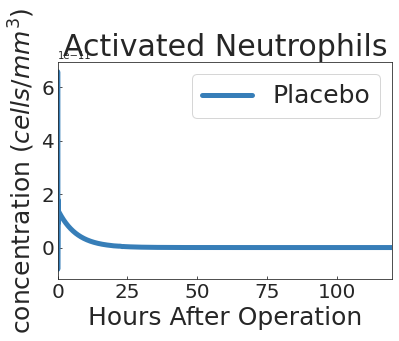

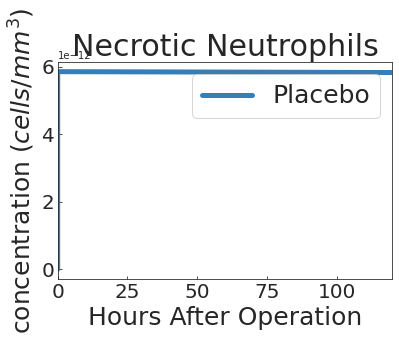

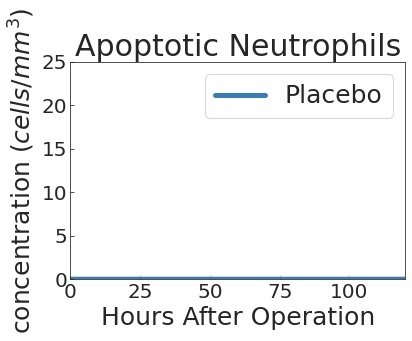

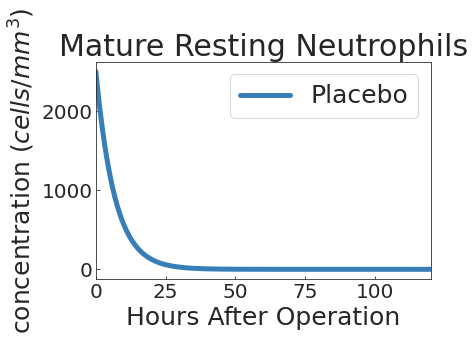

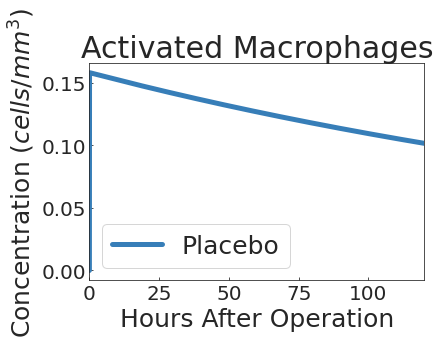

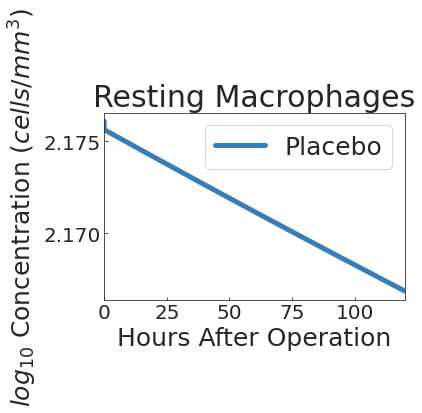

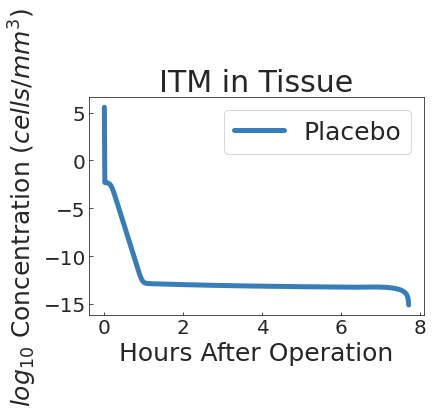

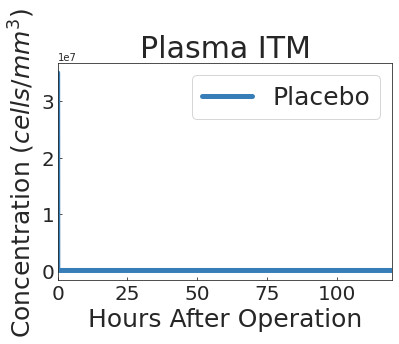

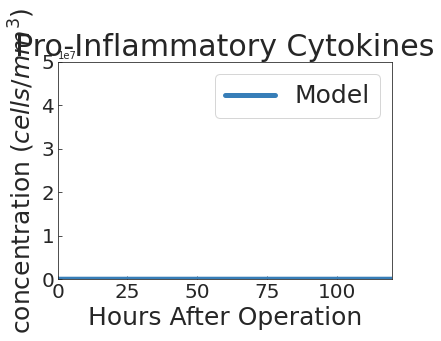

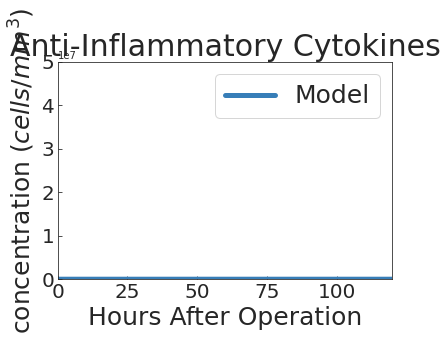

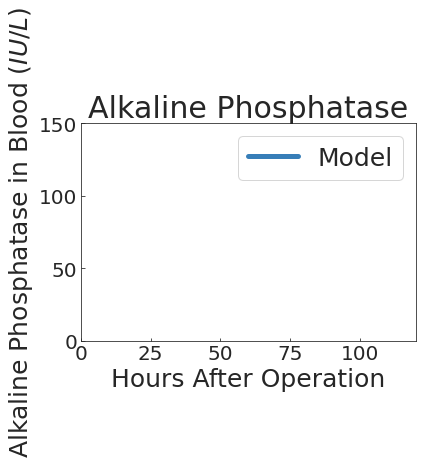

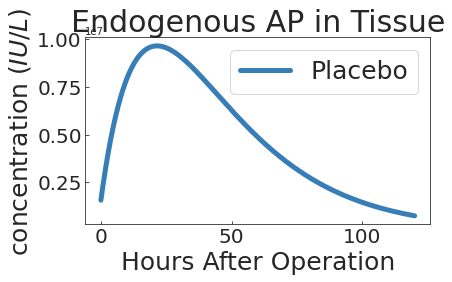

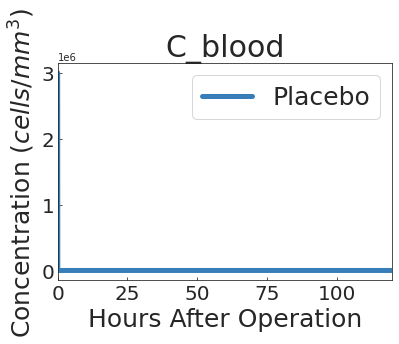

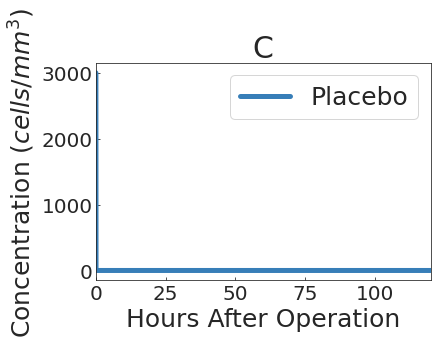

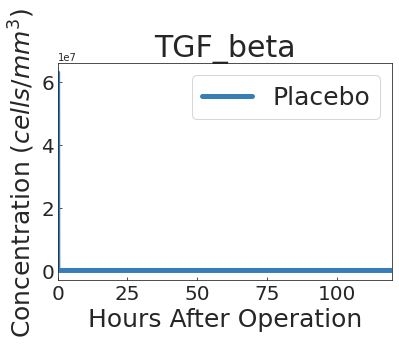

In [19]:
# phi_MRA = phi_MRA
# mu_NR = mu_NR
# mu_NA = mu_NA
# mu_NDA = mu_NDA
# mu_NDN = mu_NDN
# mu_APE = mu_APE
# mu_APSfast = mu_APSfast
# mu_APSslow = mu_APSslow
# mu_APS = mu_APS
# mu_MA = mu_MA
# mu_MR = mu_MR
# mu_ACH = mu_ACH
# mu_CH = mu_CH
# mu_ITM = mu_ITM
# lamb_ITMNA = lamb_ITMNA
# lamb_APE = lamb_APE
# lamb_APS = lamb_APS
# lamb_ITMMA = lamb_ITMMA
# lamb_MANDA = lamb_MANDA
# lamb_MANDN = lamb_MANDN
# lamb_ITMNDN = lamb_ITMNDN
# Pmax_MR = Pmax_MR
# Pmin_MR = Pmin_MR
# Pmax_NR = Pmax_NR
# Pmin_NR = Pmin_NR
# Pmax_ITM = Pmax_ITM
# Pmin_ITM = Pmin_ITM
# Keq_CH = Keq_CH
# Mmax = Mmax
# Nmax = Nmax
# ACHmax = ACHmax
# CHmax_tissue = CHmax_tissue
# ITMblood0 = ITMblood0
# ITMmax = ITMmax

# alpha_ITMNDN = alpha_ITMNDN
# alpha_ACHMA = alpha_ACHMA
# alpha_ACHMA = alpha_ACHMA

# beta_CHMA = beta_CHMA
# beta_CHNA = beta_CHNA
# beta_MANDA = beta_MANDA

# theta_ACH = theta_ACH

# ITM_source_peak = ITM_source_peak
# ITM_source_width = ITM_source_width

APEbmax_ = convert_AP(APEbmax, 'endo', 'tissue')
APElmax_ = convert_AP(APElmax, 'endo', 'tissue')
APEmax_ = convert_AP(APEmax, 'endo', 'tissue')
APSmax_ = convert_AP(APSmax, 'supp', 'blood')

# Initial Conditions
# N_R0 = N_R0
# N_A0 = N_A0
# ND_A0 = ND_A0
# ND_N0 = ND_N0
# M_R0 = M_R0
# M_A0 = M_A0
AP_S0_ = convert_AP(AP_S0, 'supp', 'blood')
AP_Ebt0 = AP_S0_ + APEbmax_
# AP_St0 = AP_St0

# AP_Et0 = convert_AP(np.copy(AP_Et0), 'endo', 'tissue')
# AP_El0 = convert_AP(AP_El0, 'endo', 'blood')
# AP_Eb0 = convert_AP(AP_Eb0, 'endo', 'blood') + AP_El0

# print(AP_Et0, AP_El0, AP_Eb0)

# CH0 = CH0
# ACH0 = ACH0
# N_B0 = N_B0

AP_Sinj = (1 * 5.6 * 80.) / (60. * 5)
AP_Sinj = convert_AP(AP_Sinj, 'supp', 'blood')

step_max = step_max

step = 'bIAP'
bound = 'bound_'
norm = 'norm_'
params = {'h': 'h4',
          'restrict': False}

beta_CHMA = 7.8e-4
beta_CHNA = 4.8e-2
theta_ACH = 1e-10
beta_MANDA = 9e1
lamb_ITMNDN = 1.e-6
alpha_ITMNDN = 1e3
Pmax_APE = 0.002
Pmin_APE = 0.0002
rdistress = 3e6  # 1e6
w_gauss_min = 8e7
rinduce_peak = 21.0
rinduce = 0.05
r_AP = 0.08
r_ITM = 0.5
r_ITMpeak = 5 * 10 ** 12
r_NDN = 0.008
lamb_MANDN = 5e-6
lamb_MANDA = 3e-5
mu_NDA = 2.5e1
Keq_CH = 2e4
r_Nhomeo = 1e-4
Pmax_NR = 6e-3

r_APhomeo = Pmin_APE + mu_APE

time = time
t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]
ITMtissue0 = ITMtissue0
ITMtrans0 = ITMtrans0

# START Complement

C_blood0 = 3e6  # *10^12
C0 = 3e3
TGF_beta0 = 6.3e7  # 62708333.333333336 # solved with 240kDa and 25 ng/ml

mu_C = 1e3
mu_TFGbeta = 1e3
alpha_CMA = 4.8e-2
alpha_TFGbetaMA = 4.8e-2
Keq_CHC = 2e4
Cmax = 2.5e1
Pmax_C = 6e-3
Pmin_C = 6e-3
r_Chomeo = 6e-3

TGF_betamax = 2e4
C_bloodmax = 2e12

# ITMblood0 = 0


# END Complement


AP_filename = AP_fle
pred_filename = pred_fle

cyto_fle = cyto_fle
sample_fle = sample_fle
trt_fle = trt_fle
german_hospital_file = german_hospital_file
dutch_hospital_file = dutch_hospital_file
treatment_file = treatment_file

# case 5 is for placebo experiment
# case 6 is for bIAP experiment
cases = [5]
case_names = ['', '', '', 'No AP', 'Placebo', 'bIAP']
patients = ['16', '51', '36', '26', '59']
treatment = 'Placebo'


df_IL10 = []
df_IL6 = []


for case in cases:
    print('Processing Case :', case, ' (', case_names[case-1], ')')

    # For looking into normal individuals
#     ITMblood0 = 0
#     ITMtissue0 = 0
# #     r_ITMpeak = 5 * 10 ** 3
#     r_ITMpeak = 1 * 10 ** 0

    p = [mu_ACH, mu_APE, mu_APS, mu_APSfast, mu_APSslow, mu_CH, mu_MA, mu_MR, mu_NA, mu_NDA, mu_NDN,
         mu_NR, mu_ITM, Pmin_MR, Pmin_NR, ACHmax, CHmax_tissue, Mmax, Nmax, Pmax_MR, Pmax_NR, Keq_CH, phi_MRA,
         theta_ACH, lamb_APE, lamb_ITMNA, lamb_ITMMA, lamb_MANDA, lamb_MANDN, lamb_APS, alpha_ACHMA, beta_CHMA,
         beta_CHNA, beta_MANDA, APEmax, APEbmax_, APElmax_, APSmax_, rdistress, lamb_ITMNDN, alpha_ITMNDN, Pmax_APE,
         Pmin_APE, rinduce_peak, AP_Sinj, w_gauss_min, r_Nhomeo, r_APhomeo, Pmax_ITM, Pmin_ITM, ITMmax, step_max,
         r_NDN, r_ITM, r_ITMpeak, r_AP, rinduce, ITM_source_peak, ITM_source_width, mu_C, mu_TFGbeta,
         alpha_CMA, alpha_TFGbetaMA, TGF_betamax, Keq_CHC, Cmax, Pmax_C, Pmin_C, r_Chomeo, C_bloodmax]

    w = [N_R0, convert_AP(AP_Eb0, 'endo', 'blood') + AP_El0, 
         convert_AP(AP_Et0, 'endo', 'tissue'), 
         convert_AP(AP_El0, 'endo', 'blood'), 
         convert_AP(AP_S0, 'supp', 'blood'), 
         AP_St0, ITMblood0, ITMtissue0,
         M_R0, M_A0, CH0, N_A0, ND_A0, ACH0, ND_N0, C_blood0, C0, TGF_beta0]

    params['case'] = case
    w0 = get_init(w, params)

    t, wsol = solve(p, w0, t, params)

    plot(wsol, case_names, time, t, df_IL6, df_IL10, params)

In [12]:
mw = 190 * 10 ** 3

mult = ((6.02 * 10 ** 23) / (mw * 10 ** 6))

In [13]:
mult * 1.6

5069473684210.526

In [14]:
mw = 240 * 10 ** 3

mult = ((1 * 10 ** -9) * (6.02 * 10 ** 23) / ((1 * 10 ** -3) * mw * 10 ** 6))

In [15]:
mult * 25

62708333.333333336